In [49]:
#CS5228 project

# data manipulation
import pandas as pd
import numpy as np
import math
import random
import pickle
import torch.optim as optim
from scipy import stats


# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE # for feature selection of LR
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample


# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


In [3]:
#load into dataframe
f_data = pd.read_csv('financial_data.csv', na_values=['?']) 
revealed = pd.read_csv('revealed_businesses.csv')
t_data = pd.read_csv('testing_data.csv', na_values=['?'])

display(f_data.head())
display(t_data.head())
display(revealed.head())

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65
0,18399,0.023954,0.150120,0.395670,3.63570,54.043,0.028822,0.031029,4.56831,1.01120,...,3871.001,0.011041,0.034914,0.98896,0.000000,9.5214,5.8248,34.713,10.5150,3.4752
1,15092,0.049699,0.065808,0.726800,12.94400,233.110,0.000000,0.063192,14.19601,0.89618,...,8751.901,0.059565,0.053189,0.93169,0.000000,5.0492,11.1520,24.784,14.7270,4.2204
2,19821,-0.356310,0.392880,0.158840,1.40430,-2.619,-0.085597,-0.356320,1.54531,0.92963,...,44.859,-0.172770,-0.586910,1.38330,0.000000,5.6112,15.7790,154.260,2.3662,2.0738
3,14171,0.001417,0.708110,-0.052312,0.88978,-31.198,0.269520,0.001407,0.41222,1.96540,...,-331.879,-0.000535,0.004820,0.99930,0.745480,17.1011,7.9482,88.147,4.1408,3.4021
4,12900,0.020041,0.346520,0.335930,2.76130,39.050,0.000000,0.020031,1.88591,1.29750,...,38170.001,0.212410,0.030652,0.80158,0.000862,9.7670,6.7570,53.651,6.8032,2.7412


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65
0,15260,0.108010,0.13924,0.830200,6.96220,473.710,0.00000,0.108000,6.18171,0.79295,...,617.791,0.283210,0.125470,0.73116,0.00000,9.7199,3.4925,64.095,5.69470,25.95000
1,14798,0.236630,0.86496,0.070858,1.08490,-18.866,-0.90779,0.276330,0.15613,2.14410,...,156.161,0.228270,1.752300,0.79460,0.00000,22.7391,3.2655,142.160,2.56760,22.79400
2,16288,0.010606,0.19772,0.423630,3.14500,58.018,0.00000,0.010596,4.05761,1.50650,...,3758.001,0.546620,0.013208,0.47022,0.00000,3.9728,6.4937,47.851,7.62790,3.97500
3,14843,0.003140,0.60277,-0.193510,0.24701,-1058.700,-0.00317,0.003130,0.65900,0.11005,...,-22384.999,0.207050,0.007880,0.79303,0.87049,2.1823,8.8410,852.310,0.42825,0.11752
4,16200,0.032548,0.35735,0.409210,2.14510,18.331,0.00000,0.032538,1.79841,2.26320,...,3866.801,0.004981,0.050632,0.98583,0.00000,7.6220,6.3231,57.632,6.33320,9.69520


,Var1,Var66
0,18399,0
1,19821,0
2,17769,0
3,19309,0
4,20728,0


In [14]:
#Data Cleaning
#display(f_data.isna().sum().sort_values(ascending=False))
#f_data_2 = f_data.drop(columns=['Var38', 'Var22', 'Var61', 'Var28', 'Var61']) #Use in case of column reduction
#columns_no_output = list(f_data_2)  #Use in case of column reduction
#t_data_reduced = t_data[columns_no_output]
f_data_merged = f_data.merge(revealed)
f_data_revealed = f_data_merged[f_data_merged.Var66 != np.nan]

f_data_positive = f_data_revealed[f_data_revealed.Var66 == 0]
f_data_negative = f_data_revealed[f_data_revealed.Var66 == 1]

f_data_positive_clean = f_data_positive.fillna(method='ffill')
f_data_positive_clean = f_data_positive_clean.dropna()
f_data_negative_clean = f_data_negative.fillna(method='ffill')
f_data_negative_clean = f_data_negative_clean.dropna()

f_data_merged_clean = f_data_positive_clean.append(f_data_negative_clean).sort_index() 
f_data_no_index = f_data_merged_clean.drop(columns=['Var1', 'Var66']) #X Training
training_y = f_data_merged_clean.Var66 #Y training
columns_no_index = list(f_data_no_index)

f_data_positive_no_output = f_data_positive_clean.drop(columns=['Var66'])
f_data_negative_no_output = f_data_negative_clean.drop(columns=['Var66'])

t_data_clean = t_data.fillna(method='bfill').drop(columns=['Var1'])
cID = t_data['Var1'].tolist()
t_data_columns = list(t_data_clean)






#f_data_limited = variance_threshold_selector(f_data_no_index_no_outliers, 0.8) #x for training
#f_data_limited_output = f_data_limited.copy(deep='true')
#f_data_limited_output['Var66'] = training_y
#columns_no_index_limited = list(f_data_limited_output)

In [26]:
#display(f_data.isna().sum())
#display(f_data_merged_clean.isnull().sum())
#display(f_data_revealed.isnull().sum())
#display(f_data_merged_clean.Var66)
count = 0
for value in y_training:
    if value == 1:
        count+=1
count

126

Data Normalizing:

In [20]:
scaler = StandardScaler()

f_data_norm = scaler.fit_transform(f_data_no_index)
f_data_normalized = pd.DataFrame(f_data_norm, columns=columns_no_index)
f_data_normalized['Var66'] = training_y.values
#f_data_normalized = f_data_normalized.sample(frac=1)

t_data_norm = scaler.fit_transform(t_data_clean)
t_data_normalized = pd.DataFrame(t_data_norm, columns=t_data_columns)

display(f_data_normalized.head())
display(t_data_normalized.head())

,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,...,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66
0,-0.031578,-0.217947,-0.023833,-0.065522,0.016436,0.043052,-0.028107,-0.024453,-0.442741,0.158892,...,0.014975,-0.010964,-0.015799,-0.038823,-0.016877,-0.103804,-0.027241,-0.213160,-0.088586,0
1,-0.114623,0.474405,-0.028456,-0.069338,0.016689,0.017261,-0.128480,-0.027264,-0.020177,-0.428242,...,0.014054,-0.036933,-0.015734,-0.044719,-0.016877,-0.134625,-0.016933,-0.303888,0.043696,0
2,-0.310244,0.519723,-0.142454,-0.065566,0.016455,0.017261,-0.323589,-0.027363,-0.643001,-0.471554,...,0.011261,-0.154133,-0.012374,0.028404,-0.016767,-0.122845,-0.022144,-0.273064,-0.096589,0
3,-0.147664,0.124218,-0.853632,-0.081879,0.015869,0.017261,-0.164845,-0.026206,-0.364337,-0.093558,...,0.014151,-0.034607,-0.015302,-0.044719,-0.016792,-0.088503,-0.016169,-0.307144,-0.094299,0
4,-0.187001,0.803238,-0.805485,-0.077174,0.022185,0.017261,-0.200669,-0.027868,0.742657,-0.742599,...,0.014853,0.613947,-0.015536,-0.194292,0.001046,-0.110785,-0.024033,-0.256083,-0.060590,0


,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,...,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65
0,0.111465,-0.059198,0.082161,0.070248,0.214767,0.025733,0.090308,-0.023223,-0.466343,0.060784,...,-0.081084,0.495542,0.030066,-0.026149,-0.058331,-0.082314,-0.123844,-0.033871,-0.078187,0.007340
1,0.312120,0.003717,0.016274,-0.129639,0.017576,-0.046425,0.351322,-0.031098,0.313527,-0.002135,...,-0.086097,0.383066,0.265854,-0.026013,-0.058331,-0.072837,-0.127529,-0.025458,-0.166636,-0.003845
2,-0.040492,-0.054128,0.046884,-0.059575,0.048355,0.025733,-0.060728,-0.025999,-0.054489,0.055714,...,-0.046986,1.034808,0.013795,-0.026707,-0.058331,-0.086497,-0.075128,-0.035621,-0.023507,-0.070540
3,-0.052139,-0.019013,-0.006665,-0.158136,-0.398698,0.025481,-0.072305,-0.030441,-0.860506,0.020596,...,-0.330861,0.339624,0.013022,-0.026017,0.017325,-0.087801,-0.037025,0.051068,-0.227147,-0.084211
4,-0.006261,-0.040289,0.045632,-0.093582,0.032467,0.025733,-0.026704,-0.028952,0.382270,0.041874,...,-0.045804,-0.074061,0.019219,-0.025604,-0.058331,-0.083841,-0.077897,-0.034567,-0.060127,-0.050267


In [21]:
#Set Splitting
index_to_round = round(len(f_data_normalized.index)*0.75)
display("Dataset will be split on index: {}".format(index_to_round))


for_training = f_data_normalized.iloc[:index_to_round, :]
for_testing = f_data_normalized.iloc[index_to_round:, :]

x_training = for_training.drop(columns=['Var66'])
y_training = for_training.Var66


x_testing = for_testing.drop(columns=['Var66'])
y_testing = for_testing.Var66

'Dataset will be split on index: 3656'

In [97]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=0.5,
                                 criterion='friedman_mse', min_samples_split=90, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0,
                                 max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1,
                                 n_iter_no_change=None, tol=0.0001)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9860503282275711 Test Score:0.9630541871921182
Test F1:0.23728813559322032


In [56]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30,
                           p=2, metric='minkowski', metric_params=None, n_jobs=-1)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9669037199124726 Test Score:0.9655172413793104
Test F1:0.04545454545454545


In [47]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=65, learning_rate=1, algorithm='SAMME.R', random_state=None)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9729212253829321 Test Score:0.9655172413793104
Test F1:0.22222222222222218


In [98]:
# write results to predictions.csv
f = open('predictions.csv', 'w')
f.write('Business_ID,Is_Bankrupted\n')
for a,b in zip(cID, clf.predict(t_data_normalized)):
    f.write(str(a))
    f.write(',')
    f.write(str(round(b)))
    f.write('\n')
f.close()

In [130]:
display(len(f_data_positive_no_outliers.index))
display(len(f_data_negative_no_outliers.index))
display(len(f_data_merged_clean_no_outliers.index))
f_data_limited_output.head()



4351

129

4480

,Var5,Var6,Var9,Var10,Var13,Var16,Var17,Var18,Var21,Var27,...,Var54,Var55,Var56,Var58,Var60,Var62,Var63,Var64,Var65,Var66
0,0.43562,-57.7230,0.33523,3.20330,0.096859,2536.00,0.143930,1.3352,18.2330,0.132920,...,0.33651,0.55900,-2618.199,0.192090,0.661150,44.5660,66.425,5.4949,4.2937,0
1,2.08670,-7.0227,1.28271,3.05860,0.197810,455.38,0.801530,2.2827,57.8130,0.801530,...,5.38780,5.38780,3099.501,0.151100,0.000000,11.2780,51.224,7.1255,29.3270,0
2,1.48990,26.8390,0.31163,1.07550,0.436690,2236.10,0.163230,1.3286,5.9790,0.141840,...,0.38374,1.18820,131000.001,0.417260,2.096400,4.4381,78.460,4.6521,1.9863,0
3,1.37680,14.0750,0.73134,1.00230,0.022541,7206.50,0.050649,1.7713,9.1468,0.044995,...,1.85380,1.85380,16796.001,0.023091,0.000000,4.7083,65.381,5.5827,14.1510,0
4,0.92578,-13.8950,0.11292,0.99882,0.611830,559.39,0.652490,1.2100,8.3496,0.688870,...,0.39678,0.39793,-5350.699,5.739400,0.002905,6.2204,72.918,5.0056,17.5850,0


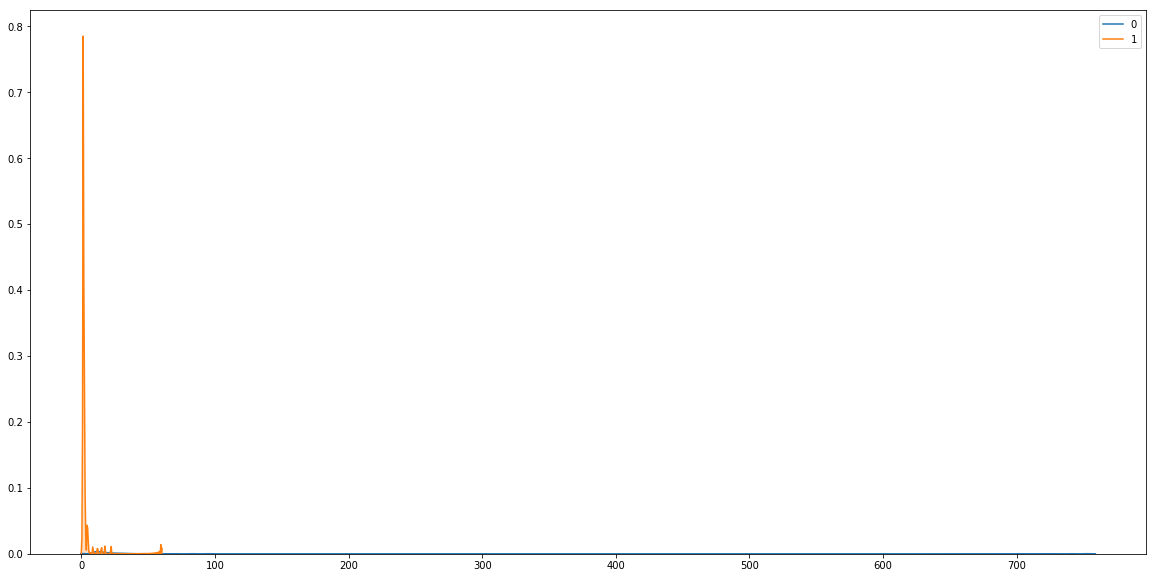

In [141]:
plt.figure(figsize=(20, 10))
gr = f_data_limited_output.groupby('Var66').Var18
for label, arr in gr:
    sb.kdeplot(arr, label=label, shade=True)

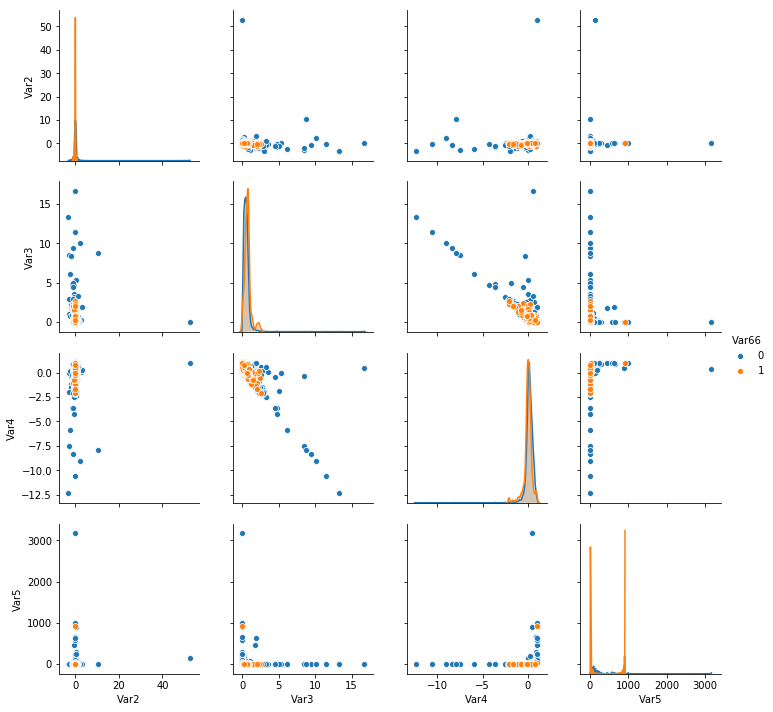

In [50]:
sb.pairplot(f_data_merged_clean, vars=('Var2','Var3','Var4','Var5'), hue='Var66')

In [54]:
for column in columns_no_index:
    display('Max value in {}: {}'.format(column, f_data_no_index[column].max()))
    display('Min value in {}: {}'.format(column, f_data_no_index[column].min()))
    display('Average value in {}: {}'.format(column, f_data_no_index[column].mean()))
    display('Standard Deviation in {}: {}'.format(column, f_data_no_index[column].std()))
    display(' ')

'Max value in Var2: 52.65201'

'Min value in Var2: -3.19199'

'Average value in Var2: 0.06197374663660586'

'Standard Deviation in Var2: 0.8026640834857937'

' '

'Max value in Var3: 16.643'

'Min value in Var3: 0.0'

'Average value in Var3: 0.544630210846485'

'Standard Deviation in Var3: 0.5858331204464181'

' '

'Max value in Var4: 1.0546'

'Min value in Var4: -12.314'

'Average value in Var4: 0.1496763805287969'

'Standard Deviation in Var4: 0.5061348392729743'

' '

'Max value in Var5: 3171.7'

'Min value in Var5: 0.0064679'

'Average value in Var5: 4.956112279240246'

'Standard Deviation in Var5: 54.6930665016095'

' '

'Max value in Var6: 685000.0'

'Min value in Var6: -11900000.0'

'Average value in Var6: -2876.729528707391'

'Standard Deviation in Var6: 173859.3981700977'

' '

'Max value in Var7: 45.533'

'Min value in Var7: -70.96600000000001'

'Average value in Var7: -0.025485006243902444'

'Standard Deviation in Var7: 1.4711008617080148'

' '

'Max value in Var8: 52.652'

'Min value in Var8: -3.1919999999999997'

'Average value in Var8: 0.07335134561180569'

'Standard Deviation in Var8: 0.8047689467460044'

' '

'Max value in Var9: 26376.00001'

'Min value in Var9: -2.0817900000000003'

'Average value in Var9: 10.62716197096675'

'Standard Deviation in Var9: 381.8865955988416'

' '

'Max value in Var10: 63.482'

'Min value in Var10: -1.2157'

'Average value in Var10: 1.8316863202480018'

'Standard Deviation in Var10: 1.8996562324312491'

' '

'Max value in Var11: 11.837'

'Min value in Var11: -15.642999999999999'

'Average value in Var11: 0.43991667212543545'

'Standard Deviation in Var11: 0.61292186392101'

' '

'Max value in Var12: 52.652'

'Min value in Var12: -3.083'

'Average value in Var12: 0.094711221317893'

'Standard Deviation in Var12: 0.8111903457804488'

' '

'Max value in Var13: 8259.4'

'Min value in Var13: -274.57'

'Average value in Var13: 3.7124436283347024'

'Standard Deviation in Var13: 155.69944271870074'

' '

'Max value in Var14: 64.035'

'Min value in Var14: -557.01'

'Average value in Var14: -0.16685672696072387'

'Standard Deviation in Var14: 11.402357522793254'

' '

'Max value in Var15: 52.652'

'Min value in Var15: -3.1919999999999997'

'Average value in Var15: 0.07335134561180569'

'Standard Deviation in Var15: 0.8047689467460044'

' '

'Max value in Var16: 1380000.0'

'Min value in Var16: -602000.0'

'Average value in Var16: 2253.2572737147834'

'Standard Deviation in Var16: 35804.69093655234'

' '

'Max value in Var17: 8259.4'

'Min value in Var17: -82.677'

'Average value in Var17: 3.9770815273399016'

'Standard Deviation in Var17: 155.640358125012'

' '

'Max value in Var18: 26382.0'

'Min value in Var18: 0.060085'

'Average value in Var18: 11.708936294540228'

'Standard Deviation in Var18: 381.9599403458716'

' '

'Max value in Var19: 52.652'

'Min value in Var19: -3.1919999999999997'

'Average value in Var19: 0.07335134561180569'

'Standard Deviation in Var19: 0.8047689467460044'

' '

'Max value in Var20: 16.761'

'Min value in Var20: -576.12'

'Average value in Var20: -0.23565780270409215'

'Standard Deviation in Var20: 11.622432593520433'

' '

'Max value in Var21: 91600.0'

'Min value in Var21: 0.0'

'Average value in Var21: 72.56078642882994'

'Standard Deviation in Var21: 1369.491615708576'

' '

'Max value in Var23: 47.597'

'Min value in Var23: -3.0891'

'Average value in Var23: 0.08568606933183029'

'Standard Deviation in Var23: 0.7329626248062941'

' '

'Max value in Var24: 16.761'

'Min value in Var24: -576.12'

'Average value in Var24: -0.2427194997388444'

'Standard Deviation in Var24: 11.562478089117128'

' '

'Max value in Var25: 45.533'

'Min value in Var25: -6.2032'

'Average value in Var25: 0.20266360266038122'

'Standard Deviation in Var25: 0.8866226115583242'

' '

'Max value in Var26: 2.0661'

'Min value in Var26: -20.102999999999998'

'Average value in Var26: 0.2781334708116417'

'Standard Deviation in Var26: 0.7573207401012558'

' '

'Max value in Var27: 8262.3'

'Min value in Var27: -82.677'

'Average value in Var27: 3.9153133045155992'

'Standard Deviation in Var27: 155.66948204808168'

' '

'Max value in Var29: 2770.0'

'Min value in Var29: -227.08'

'Average value in Var29: 3.8108528991968216'

'Standard Deviation in Var29: 52.920817462285655'

' '

'Max value in Var30: 7.7381'

'Min value in Var30: 0.91084'

'Average value in Var30: 3.9312144886247187'

'Standard Deviation in Var30: 0.83640161496899'

' '

'Max value in Var31: 1372.0'

'Min value in Var31: -495.41'

'Average value in Var31: 0.9788312611700595'

'Standard Deviation in Var31: 25.687510180797915'

' '

'Max value in Var32: 16.761'

'Min value in Var32: -576.12'

'Average value in Var32: -0.22355066639111662'

'Standard Deviation in Var32: 11.62216177771633'

' '

'Max value in Var33: 1750000.0'

'Min value in Var33: -9295.6'

'Average value in Var33: 635.8256888966941'

'Standard Deviation in Var33: 25451.526627444942'

' '

'Max value in Var34: 708.92'

'Min value in Var34: -1.9219'

'Average value in Var34: 8.721601554997946'

'Standard Deviation in Var34: 22.807163627401035'

' '

'Max value in Var35: 6348.5'

'Min value in Var35: -24.465'

'Average value in Var35: 6.338663876841132'

'Standard Deviation in Var35: 92.5758317581377'

' '

'Max value in Var36: 47.597'

'Min value in Var36: -3.0891'

'Average value in Var36: 0.07946054133551957'

'Standard Deviation in Var36: 0.7367505273555987'

' '

'Max value in Var37: 63.482'

'Min value in Var37: 0.0'

'Average value in Var37: 2.126119679133019'

'Standard Deviation in Var37: 2.10921717764318'

' '

'Max value in Var39: 13.655999999999999'

'Min value in Var39: -15.642999999999999'

'Average value in Var39: 0.5459673853986473'

'Standard Deviation in Var39: 0.581125487778101'

' '

'Max value in Var40: 4.9902'

'Min value in Var40: -551.11'

'Average value in Var40: -0.21265886606641993'

'Standard Deviation in Var40: 10.955454010008127'

' '

'Max value in Var41: 1637.9'

'Min value in Var41: -7.0819'

'Average value in Var41: 2.260630570281314'

'Standard Deviation in Var41: 31.875805377760297'

' '

'Max value in Var42: 289000.0'

'Min value in Var42: -58.523'

'Average value in Var42: 60.65790702448656'

'Standard Deviation in Var42: 4170.919385591181'

' '

'Max value in Var43: 38.4'

'Min value in Var43: -551.11'

'Average value in Var43: -0.19260486981492908'

'Standard Deviation in Var43: 10.968863625833773'

' '

'Max value in Var44: 159000.0'

'Min value in Var44: -52.472'

'Average value in Var44: 171.0946777709233'

'Standard Deviation in Var44: 2362.9214467279435'

' '

'Max value in Var45: 67406.0'

'Min value in Var45: -55.38399999999999'

'Average value in Var45: 98.53508275303311'

'Standard Deviation in Var45: 1081.6380745960466'

' '

'Max value in Var46: 98924.0'

'Min value in Var46: -74385.0'

'Average value in Var46: 9.644214128144839'

'Standard Deviation in Var46: 1833.768250900431'

' '

'Max value in Var47: 3171.7'

'Min value in Var47: -6.4692'

'Average value in Var47: 3.971924864989733'

'Standard Deviation in Var47: 52.69555079210702'

' '

'Max value in Var48: 2590000.0'

'Min value in Var48: -17.303'

'Average value in Var48: 689.5959164682076'

'Standard Deviation in Var48: 37330.87750433627'

' '

'Max value in Var49: 47.597'

'Min value in Var49: -8.9691'

'Average value in Var49: 0.019528195532998564'

'Standard Deviation in Var49: 0.7632301798990556'

' '

'Max value in Var50: 36.156'

'Min value in Var50: -556.59'

'Average value in Var50: -0.26176503602946743'

'Standard Deviation in Var50: 11.246976891242033'

' '

'Max value in Var51: 991.19'

'Min value in Var51: 0.0064679'

'Average value in Var51: 3.515070420956486'

'Standard Deviation in Var51: 30.773230480262193'

' '

'Max value in Var52: 13.314'

'Min value in Var52: 0.0'

'Average value in Var52: 0.4156633731522853'

'Standard Deviation in Var52: 0.4891485398304453'

' '

'Max value in Var53: 84827.0'

'Min value in Var53: -25.467'

'Average value in Var53: 19.22638163730666'

'Standard Deviation in Var53: 1220.1436574360732'

' '

'Max value in Var54: 2771.0'

'Min value in Var54: -517.88'

'Average value in Var54: 3.844935258531688'

'Standard Deviation in Var54: 52.013520315754825'

' '

'Max value in Var55: 2771.0'

'Min value in Var55: -228.16'

'Average value in Var55: 4.449842695180925'

'Standard Deviation in Var55: 51.115968428997434'

' '

'Max value in Var56: 2650000.001'

'Min value in Var56: -419999.999'

'Average value in Var56: 6670.487833293707'

'Standard Deviation in Var56: 58005.46455801292'

' '

'Max value in Var57: 2.7633'

'Min value in Var57: -5691.7'

'Average value in Var57: -1.237718687435739'

'Standard Deviation in Var57: 81.9738509544503'

' '

'Max value in Var58: 552.64'

'Min value in Var58: -177.85'

'Average value in Var58: 0.16810885011067844'

'Standard Deviation in Var58: 9.13228697902116'

' '

'Max value in Var59: 5693.7'

'Min value in Var59: -1.3281'

'Average value in Var59: 2.3061830405015415'

'Standard Deviation in Var59: 82.03509730424767'

' '

'Max value in Var60: 853.09'

'Min value in Var60: -136.29'

'Average value in Var60: 0.6752673073416683'

'Standard Deviation in Var60: 15.109501479251755'

' '

'Max value in Var62: 4470.4'

'Min value in Var62: -6.5903'

'Average value in Var62: 16.76950965592281'

'Standard Deviation in Var62: 108.92159864584228'

' '

'Max value in Var63: 502000.0'

'Min value in Var63: 0.0'

'Average value in Var63: 304.2897789779972'

'Standard Deviation in Var63: 8076.5076834422725'

' '

'Max value in Var64: 740.73'

'Min value in Var64: 0.0'

'Average value in Var64: 9.400201588997946'

'Standard Deviation in Var64: 23.757027686544124'

' '

'Max value in Var65: 12569.0'

'Min value in Var65: 0.0'

'Average value in Var65: 30.01675439831834'

'Standard Deviation in Var65: 301.1236569883393'

' '

'Max value in Var66: 1'

'Min value in Var66: 0'

'Average value in Var66: 0.03484320557491289'

'Standard Deviation in Var66: 0.18340133763476413'

' '

In [72]:
for column in columns_no_index:
    display('Max value in {}: {}'.format(column, f_data_no_index_no_outliers[column].max()))
    display('Min value in {}: {}'.format(column, f_data_no_index_no_outliers[column].min()))
    display('Average value in {}: {}'.format(column, f_data_no_index_no_outliers[column].mean()))
    display('Standard Deviation in {}: {}'.format(column, f_data_no_index_no_outliers[column].std()))
    display(' ')

'Max value in Var2: nan'

'Min value in Var2: nan'

'Average value in Var2: nan'

'Standard Deviation in Var2: nan'

' '

'Max value in Var3: nan'

'Min value in Var3: nan'

'Average value in Var3: nan'

'Standard Deviation in Var3: nan'

' '

'Max value in Var4: nan'

'Min value in Var4: nan'

'Average value in Var4: nan'

'Standard Deviation in Var4: nan'

' '

'Max value in Var5: nan'

'Min value in Var5: nan'

'Average value in Var5: nan'

'Standard Deviation in Var5: nan'

' '

'Max value in Var6: nan'

'Min value in Var6: nan'

'Average value in Var6: nan'

'Standard Deviation in Var6: nan'

' '

'Max value in Var7: nan'

'Min value in Var7: nan'

'Average value in Var7: nan'

'Standard Deviation in Var7: nan'

' '

'Max value in Var8: nan'

'Min value in Var8: nan'

'Average value in Var8: nan'

'Standard Deviation in Var8: nan'

' '

'Max value in Var9: nan'

'Min value in Var9: nan'

'Average value in Var9: nan'

'Standard Deviation in Var9: nan'

' '

'Max value in Var10: nan'

'Min value in Var10: nan'

'Average value in Var10: nan'

'Standard Deviation in Var10: nan'

' '

'Max value in Var11: nan'

'Min value in Var11: nan'

'Average value in Var11: nan'

'Standard Deviation in Var11: nan'

' '

'Max value in Var12: nan'

'Min value in Var12: nan'

'Average value in Var12: nan'

'Standard Deviation in Var12: nan'

' '

'Max value in Var13: nan'

'Min value in Var13: nan'

'Average value in Var13: nan'

'Standard Deviation in Var13: nan'

' '

'Max value in Var14: nan'

'Min value in Var14: nan'

'Average value in Var14: nan'

'Standard Deviation in Var14: nan'

' '

'Max value in Var15: nan'

'Min value in Var15: nan'

'Average value in Var15: nan'

'Standard Deviation in Var15: nan'

' '

'Max value in Var16: nan'

'Min value in Var16: nan'

'Average value in Var16: nan'

'Standard Deviation in Var16: nan'

' '

'Max value in Var17: nan'

'Min value in Var17: nan'

'Average value in Var17: nan'

'Standard Deviation in Var17: nan'

' '

'Max value in Var18: nan'

'Min value in Var18: nan'

'Average value in Var18: nan'

'Standard Deviation in Var18: nan'

' '

'Max value in Var19: nan'

'Min value in Var19: nan'

'Average value in Var19: nan'

'Standard Deviation in Var19: nan'

' '

'Max value in Var20: nan'

'Min value in Var20: nan'

'Average value in Var20: nan'

'Standard Deviation in Var20: nan'

' '

'Max value in Var21: nan'

'Min value in Var21: nan'

'Average value in Var21: nan'

'Standard Deviation in Var21: nan'

' '

'Max value in Var23: nan'

'Min value in Var23: nan'

'Average value in Var23: nan'

'Standard Deviation in Var23: nan'

' '

'Max value in Var24: nan'

'Min value in Var24: nan'

'Average value in Var24: nan'

'Standard Deviation in Var24: nan'

' '

'Max value in Var25: nan'

'Min value in Var25: nan'

'Average value in Var25: nan'

'Standard Deviation in Var25: nan'

' '

'Max value in Var26: nan'

'Min value in Var26: nan'

'Average value in Var26: nan'

'Standard Deviation in Var26: nan'

' '

'Max value in Var27: nan'

'Min value in Var27: nan'

'Average value in Var27: nan'

'Standard Deviation in Var27: nan'

' '

'Max value in Var29: nan'

'Min value in Var29: nan'

'Average value in Var29: nan'

'Standard Deviation in Var29: nan'

' '

'Max value in Var30: nan'

'Min value in Var30: nan'

'Average value in Var30: nan'

'Standard Deviation in Var30: nan'

' '

'Max value in Var31: nan'

'Min value in Var31: nan'

'Average value in Var31: nan'

'Standard Deviation in Var31: nan'

' '

'Max value in Var32: nan'

'Min value in Var32: nan'

'Average value in Var32: nan'

'Standard Deviation in Var32: nan'

' '

'Max value in Var33: nan'

'Min value in Var33: nan'

'Average value in Var33: nan'

'Standard Deviation in Var33: nan'

' '

'Max value in Var34: nan'

'Min value in Var34: nan'

'Average value in Var34: nan'

'Standard Deviation in Var34: nan'

' '

'Max value in Var35: nan'

'Min value in Var35: nan'

'Average value in Var35: nan'

'Standard Deviation in Var35: nan'

' '

'Max value in Var36: nan'

'Min value in Var36: nan'

'Average value in Var36: nan'

'Standard Deviation in Var36: nan'

' '

'Max value in Var37: nan'

'Min value in Var37: nan'

'Average value in Var37: nan'

'Standard Deviation in Var37: nan'

' '

'Max value in Var39: nan'

'Min value in Var39: nan'

'Average value in Var39: nan'

'Standard Deviation in Var39: nan'

' '

'Max value in Var40: nan'

'Min value in Var40: nan'

'Average value in Var40: nan'

'Standard Deviation in Var40: nan'

' '

'Max value in Var41: nan'

'Min value in Var41: nan'

'Average value in Var41: nan'

'Standard Deviation in Var41: nan'

' '

'Max value in Var42: nan'

'Min value in Var42: nan'

'Average value in Var42: nan'

'Standard Deviation in Var42: nan'

' '

'Max value in Var43: nan'

'Min value in Var43: nan'

'Average value in Var43: nan'

'Standard Deviation in Var43: nan'

' '

'Max value in Var44: nan'

'Min value in Var44: nan'

'Average value in Var44: nan'

'Standard Deviation in Var44: nan'

' '

'Max value in Var45: nan'

'Min value in Var45: nan'

'Average value in Var45: nan'

'Standard Deviation in Var45: nan'

' '

'Max value in Var46: nan'

'Min value in Var46: nan'

'Average value in Var46: nan'

'Standard Deviation in Var46: nan'

' '

'Max value in Var47: nan'

'Min value in Var47: nan'

'Average value in Var47: nan'

'Standard Deviation in Var47: nan'

' '

'Max value in Var48: nan'

'Min value in Var48: nan'

'Average value in Var48: nan'

'Standard Deviation in Var48: nan'

' '

'Max value in Var49: nan'

'Min value in Var49: nan'

'Average value in Var49: nan'

'Standard Deviation in Var49: nan'

' '

'Max value in Var50: nan'

'Min value in Var50: nan'

'Average value in Var50: nan'

'Standard Deviation in Var50: nan'

' '

'Max value in Var51: nan'

'Min value in Var51: nan'

'Average value in Var51: nan'

'Standard Deviation in Var51: nan'

' '

'Max value in Var52: nan'

'Min value in Var52: nan'

'Average value in Var52: nan'

'Standard Deviation in Var52: nan'

' '

'Max value in Var53: nan'

'Min value in Var53: nan'

'Average value in Var53: nan'

'Standard Deviation in Var53: nan'

' '

'Max value in Var54: nan'

'Min value in Var54: nan'

'Average value in Var54: nan'

'Standard Deviation in Var54: nan'

' '

'Max value in Var55: nan'

'Min value in Var55: nan'

'Average value in Var55: nan'

'Standard Deviation in Var55: nan'

' '

'Max value in Var56: nan'

'Min value in Var56: nan'

'Average value in Var56: nan'

'Standard Deviation in Var56: nan'

' '

'Max value in Var57: nan'

'Min value in Var57: nan'

'Average value in Var57: nan'

'Standard Deviation in Var57: nan'

' '

'Max value in Var58: nan'

'Min value in Var58: nan'

'Average value in Var58: nan'

'Standard Deviation in Var58: nan'

' '

'Max value in Var59: nan'

'Min value in Var59: nan'

'Average value in Var59: nan'

'Standard Deviation in Var59: nan'

' '

'Max value in Var60: nan'

'Min value in Var60: nan'

'Average value in Var60: nan'

'Standard Deviation in Var60: nan'

' '

'Max value in Var62: nan'

'Min value in Var62: nan'

'Average value in Var62: nan'

'Standard Deviation in Var62: nan'

' '

'Max value in Var63: nan'

'Min value in Var63: nan'

'Average value in Var63: nan'

'Standard Deviation in Var63: nan'

' '

'Max value in Var64: nan'

'Min value in Var64: nan'

'Average value in Var64: nan'

'Standard Deviation in Var64: nan'

' '

'Max value in Var65: nan'

'Min value in Var65: nan'

'Average value in Var65: nan'

'Standard Deviation in Var65: nan'

' '

'Max value in Var66: nan'

'Min value in Var66: nan'

'Average value in Var66: nan'

'Standard Deviation in Var66: nan'

' '

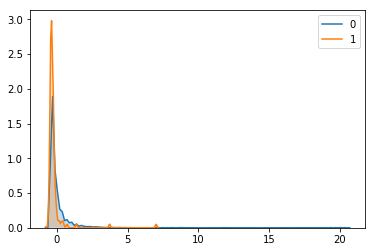

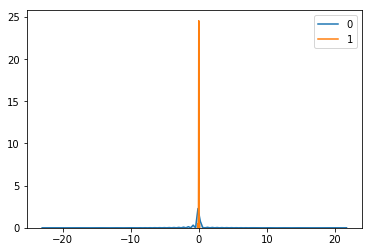

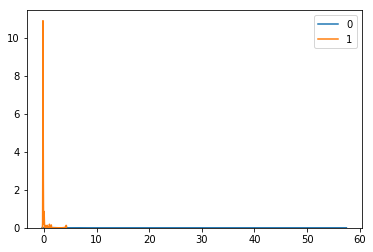

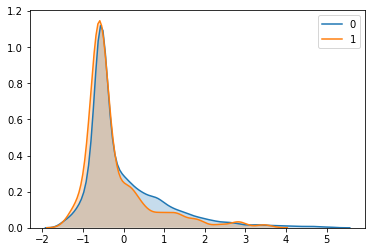

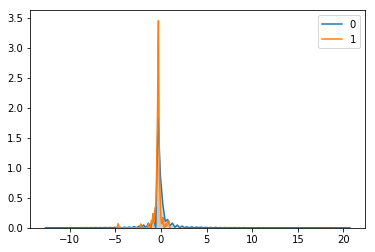

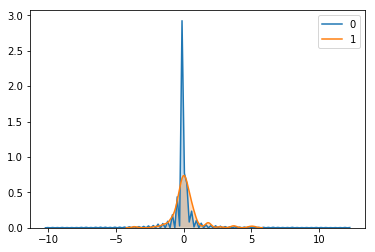

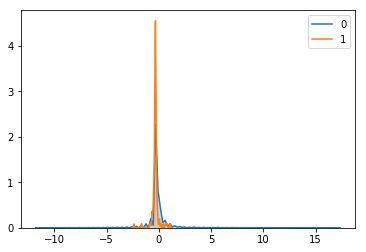

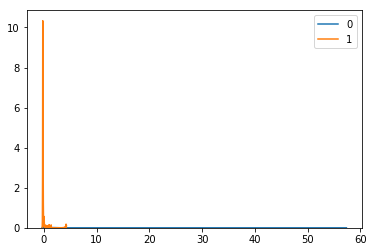

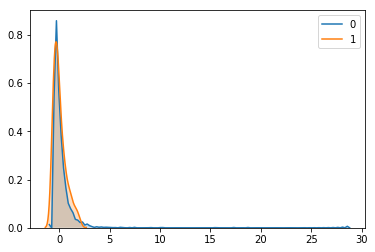

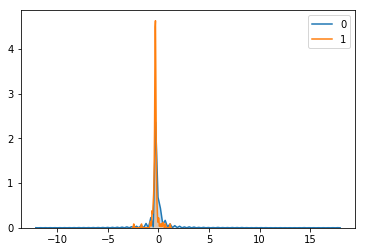

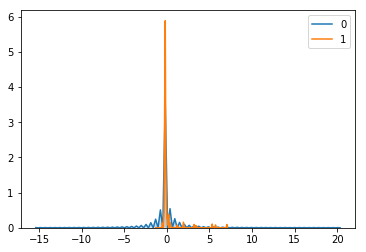

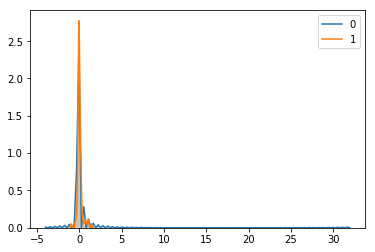

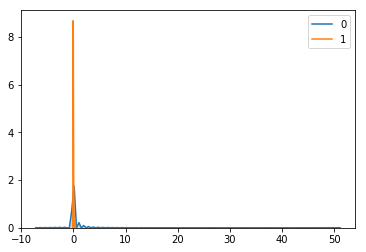

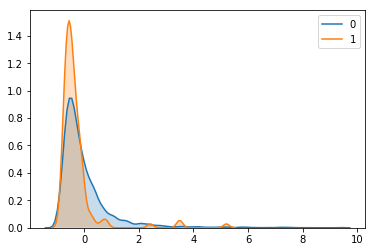

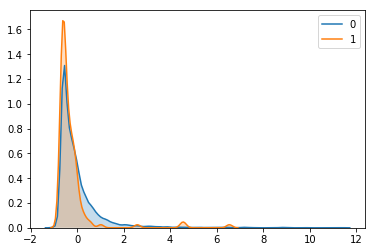

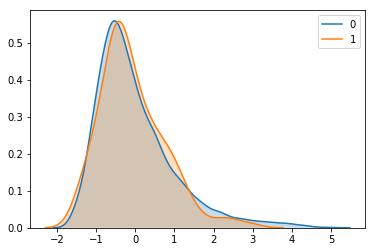

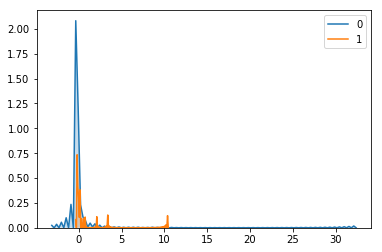

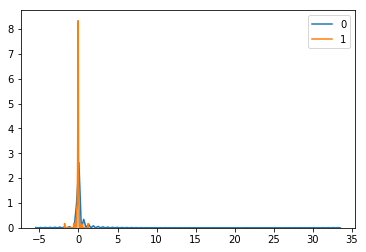

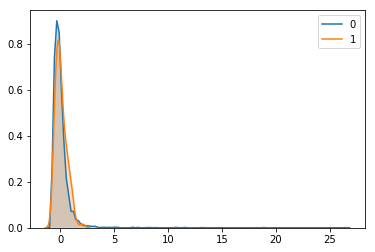

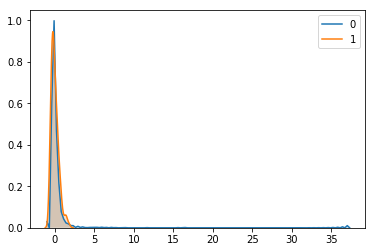

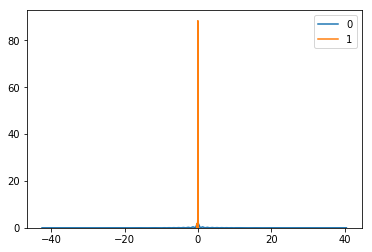

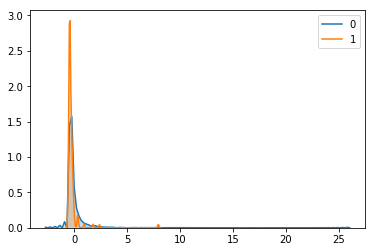

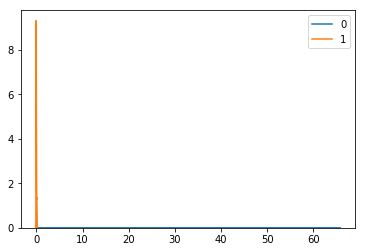

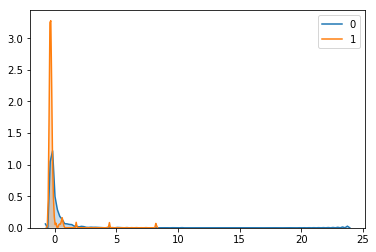

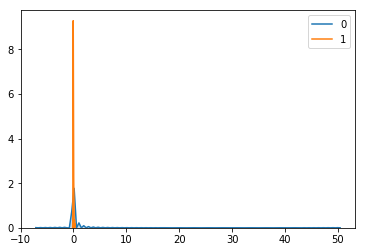

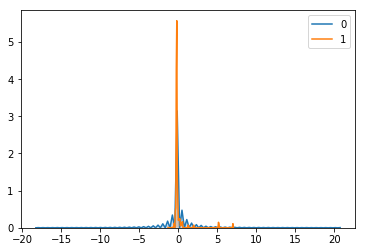

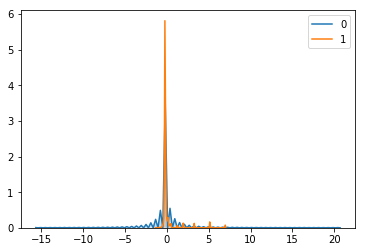

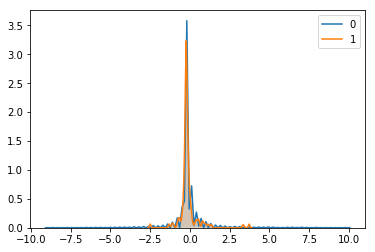

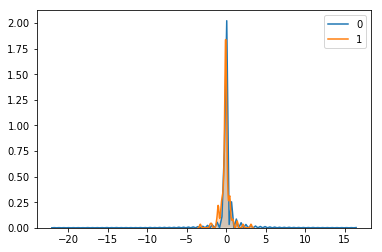

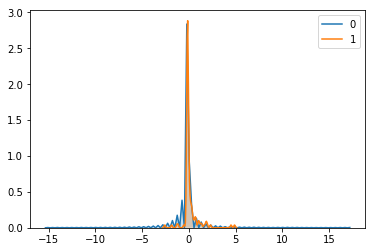

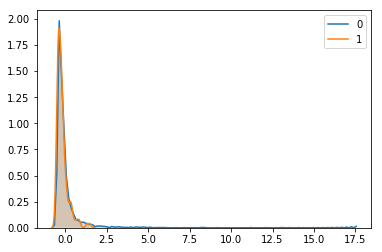

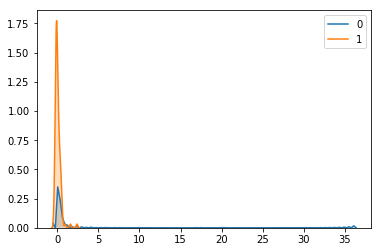

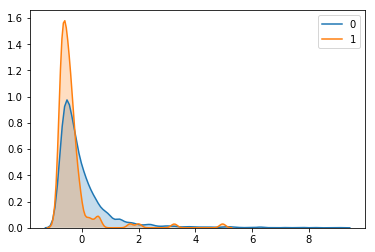

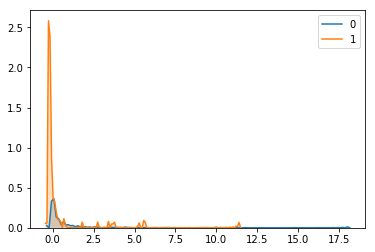

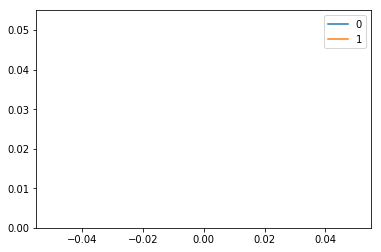

In [157]:
for i, column in enumerate(columns_no_index_limited):
    plt.figure(i)
    gr = f_data_normalized.groupby('Var66')[column]
    for label, arr in gr:
        sb.kdeplot(arr, label=label, shade=True)